# 神经网络的学习（训练）

"学习"是指从训练数据中自动获取最优权重参数的过程，学习的目的就是以损失函数为基准，找到使损失函数值最小化的权重参数。

本章主要利用了函数斜率的梯度法。

神经网络的特征是从数据中学习而来的，即由数据自动决定权重参数的值。

机器学习中，为了训练模型和评价模型的泛化能力，一般将数据分为训练数据和测试数据。所谓泛化能力，是指模型在处理未被观察过的数据（如测试数据）上的表现。获得泛化能力是机器学习的最终目标。

只对某个数据集过度拟合的状态称为过拟合。


## 损失函数

神经网络的学习通过某个指标表示现在的状态，然后以这个指标为基准，寻找最优权重参数。这个指标就是**损失函数（Loss Function）**。它可以是任意函数，但一般用均方误差和交叉熵误差等。

损失函数是表示神经网络性能的“恶劣程度”的指标，即当前的神经网络对监督数据在多大程度上不拟合，在多大程度上不一致。

### 均方误差 Mean Squared Error

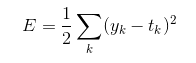

yk是表示神经网络的输出，tk表示监督数据，k表示数据的维度。

In [3]:
import numpy as np

In [4]:
# 均方误差函数
def mean_squared_error(y, t):
    return 0.5 * np.sum((y - t) ** 2)

y1 = np.array([0.1, 0.05, 0.6, 0.0, 0.05, 0.1, 0.0, 0.1, 0.0, 0.0])
y2 = np.array([0.1, 0.05, 0.1, 0.0, 0.05, 0.1, 0.0, 0.6, 0.0, 0.0])
t = np.array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0]) # one-hot encoded

e = mean_squared_error(y1, t)
print(e)
e = mean_squared_error(y2, t)
print(e)

0.09750000000000003
0.5975


### 交叉熵误差 Cross Entropy Error

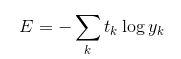

log表示以e为底的对数，log2(8)=3。yk是神经网络的输出，tk是正确解标签。并且，tk中只有正确解标签的索引为1，其余为0（one-hot表示）。

交叉熵误差的值是由正确解标签所对应的输出结果决定的。

In [5]:
def cross_entropy_error(y, t):
    delta = 1e-7
    return -np.sum(t * np.log(y + delta))

e = cross_entropy_error(y1, t)
print(e)
e = cross_entropy_error(y2, t)
print(e)

0.510825457099338
2.302584092994546


### mini-batch

如果要求所有训练数据的损失函数的综合，以交叉熵误差为例，可以写为：

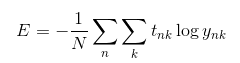

这里，假设有N个数据，tnk表示第n个数据的第k个元素的值。计算损失函数时，对每个数据的Loss进行求和，再除以N，从而正则化。

但是，如果直接求和，那么计算量会很大。比如，MNIST数据集有60000个样本，每个样本有784个元素，那么计算量是784*60000。需要耗费大量的计算资源。

因此，我们引入mini-batch的概念，将样本分为多个batch，每个batch有m个样本。例如，将样本分为100个batch，每个batch有600个样本。

In [6]:
from dataset.mnist import load_mnist

(x_train, t_train), (x_test, t_test) = load_mnist(normolize=True, one_hot_label=True)
print(x_train.shape)
print(t_train.shape)


Loading dataset ...
(60000, 784)
(60000, 10)


In [7]:
# 从训练集中抽取10笔数据
train_size = x_train.shape[0]
batch_size = 10
batch_mask = np.random.choice(train_size, batch_size) 
print(batch_mask)
# x_batch = x_train[batch_mask]
# t_batch = t_train[batch_mask]

[19033  2317 40849 55893 57784 25697  1529  5030 52391  9487]


### mini-batch版交叉熵误差的实现

In [8]:
def cross_entropy_error_mini(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)

    batch_size = y.shape[0]
    # 如果标签数据是one-hot形式，如[0, 1, 0, 0]。
    loss = -np.sum(t * np.log(y + 1e-7)) / batch_size
    # 如果标签数据不是one-hot形式，如[0, 1, 2, 3]。
    loss = -np.sum(np.log(y[np.arange(batch_size), t] + 1e-7)) / batch_size
    return loss

**损失函数的意义**

假设有一个神经网络，现在我们来关注这个神经网络中的某一个权重参数。此时，对该权重参数的损失函数求导，表示的是“如果稍微改变这个权重参数的值，损失函数的值会如何变化”。如果导数的值为负，通过使该权重参数向正方向改变，可以减小损失函数的值；反过来，如果导数的值为正，则通过使该权重参数向负方 向改变，可以减小损失函数的值。不过，当导数的值为0时，无论权重参数向哪个方向变化，损失函数的值都不会改变，此时该权重参数的更新会停在此处。

在进行神经网络的学习时，不能将识别精度作为指标。因为，如果将识别精度作为指标，则参数的导数在绝大多数地方都会变为0。

因此，损失函数的意义在于，它表示的是“如果将神经网络中的某一个权重参数向正方向改变，损失函数的值会如何变化”。

通过梯度下降算法，神经网络的学习过程就是不断改变权重参数的过程。

## 数值微分

假设有函数如下：

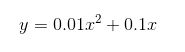

计算f(x)相对于x的变化量，对应着函数的斜率，即导数。

In [9]:
def numerical_diff(f, x):
    h = 1e-4  # 0.0001
    return (f(x + h) - f(x - h)) / (2 * h)

def function_1(x):
    return 0.01 * x**2 + 0.1*x

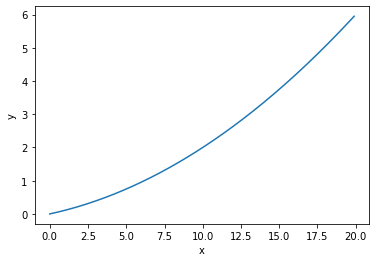

0.1999999999990898
0.2999999999986347


In [10]:
import matplotlib.pylab as plt

x = np.arange(0.0, 20.0, 0.1)  # 以0.1为步长，生成20个点。
y = function_1(x)
plt.xlabel("x")
plt.ylabel("y")
plt.plot(x, y)
plt.show()

print(numerical_diff(function_1, 5.0))
print(numerical_diff(function_1, 10.0))

0.1999999999990898


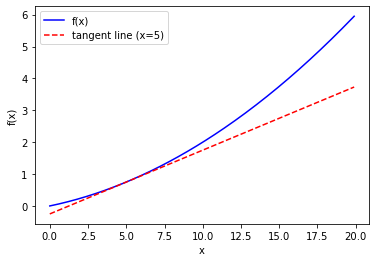

In [11]:
# 计算函数f在点x处的切线斜率。
def tangent_line(f, x):
    d = numerical_diff(f, x)
    print(d)
    y = f(x) - d * x
    return lambda t: d * t + y

plt.xlabel("x")
plt.ylabel("f(x)")
tf = tangent_line(function_1, 5)
y2 = tf(x)
plt.plot(x, y, "b-", label="f(x)")
plt.plot(x, y2, "r--", label="tangent line (x=5)")
plt.legend()
plt.show()

## 梯度

假设有函数f(x0, x1)=x0^2+x1^2, 对x0求偏导为2x0, x1求偏导为2x1，则梯度为(2x0, 2x1)，因此认为梯度是函数在点(x0, x1)处的方向导数，由全部变量的偏导数汇总而成的向量，被称为**梯度（Gradient）**。

In [12]:
def numerical_gradient_no_batch(f, x):
    h = 1e-4  # 0.0001
    grad = np.zeros_like(x)  # 生成和x形状相同的数组，元素全为0。

    for idx in range(x.size):
        tmp_val = x[idx]
        x[idx] = tmp_val + h
        fxh1 = f(x)  # f(x+h)

        x[idx] = tmp_val - h
        fxh2 = f(x)  # f(x-h)

        grad[idx] = (fxh1 - fxh2) / (2 * h)
        x[idx] = tmp_val  # 还原值
    
    return grad

In [13]:
def function_2(x):
    return np.sum(x ** 2)

g1 = numerical_gradient_no_batch(function_2, np.array([3.0, 4.0]))
print(g1)
g1 = numerical_gradient_no_batch(function_2, np.array([0.0, 2.0]))
print(g1)
g1 = numerical_gradient_no_batch(function_2, np.array([3.0, 0.0]))
print(g1)

[6. 8.]
[0. 4.]
[6. 0.]


以上是当x为(m,)形状的数据时，梯度的计算。如果输入x为(m,n)形状的数据，就需要进行迭代，即对每个样本进行梯度计算。

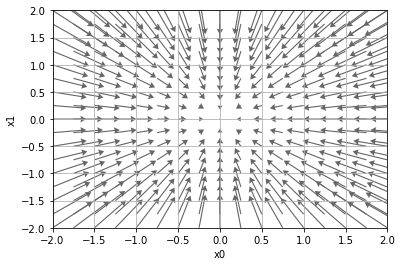

In [14]:
def numerical_gradient(f, X):
    if X.ndim == 1:
        return numerical_gradient_no_batch(f, X)
    else:
        grad = np.zeros_like(X)
        for idx, x in enumerate(X):
            grad[idx] = numerical_gradient_no_batch(f, x)
    
    return grad

x0 = np.arange(-2, 2.5, 0.25)
x1 = np.arange(-2, 2.5, 0.25)
X, Y = np.meshgrid(x0, x1) # meshgrid()函数的作用是生成一个矩形网格。
X = X.flatten()
Y = Y.flatten()
grad = numerical_gradient(function_2, np.array([X, Y]))

plt.figure() # 创建一个绘图窗口
plt.quiver(X, Y, -grad[0], -grad[1], angles="xy", headwidth=6, scale=40, color="#666666") # 绘制箭头
plt.xlim(-2, 2)
plt.ylim(-2, 2)
plt.xlabel('x0')
plt.ylabel('x1')
plt.grid()
plt.draw()
plt.show()


如上图所示，梯度指向了最低处，但并非任何时候都这样。

**实际上，梯度会指向各点处的函数值降低的方向，严格来说，梯度指示的方向是各点处的函数值减小最多的方向。**

### 梯度法

机器学习的主要任务是在学习时寻找最优参数，在神经网络中，参数就是权重和偏置。所谓最优参数，就是使损失函数最小化的参数。

一般而言，损失函数很复杂，参数空间庞大，不知道它最小值的位置。因此，通过巧妙地使用梯度来寻找函数最小值的方法成为机器学习的重要技术，这个方法叫做**梯度法（或梯度下降法）**。它是通过不断地沿着梯度方向前进，逐渐减小损失函数值，从而找到损失函数的最小值的过程。

假设有如下式：

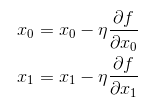

η表示更新量，也称为学习率(Learning Rate)。它决定了在一次学习中，应该学习多少，以及在多大程度上更新参数。
上式表示更新一次，这个步骤会反复执行。

学习率需要事先确定为某个值，比如0.01或0.001。一般而言，这个值过大或过小，都无法抵达一个“好的位置”。在神经网络的学习中，一般会一边改变学习率的值，一边确认学习是否正确进行了。

**实现梯度下降法**

In [15]:
def gradient_desent(f, init_x, lr=0.01, step_num=100):
    x = init_x
    x_history = []

    for i in range(step_num):
        x_history.append( x.copy() )

        grad = numerical_gradient(f, x)
        x -= lr * grad

    return x, np.array(x_history)

参数f是要进行最优化的函数，init_ x是初始值，lr是学习率learning rate，step_num是梯度法的重复次数。

numerical_ gradient(f,x)会求函数的梯度，用该梯度乘以学习率得到的值进行更新操作，由step_num指定重复的次数。使用这个函数可以求函数的极小值，顺利的话，还可以求函数的最小值。

In [16]:
init_x = np.array([-3.0, 4.0])
x, x_history = gradient_desent(function_2, init_x, lr=0.1, step_num=100)
print(x)

[-6.11110793e-10  8.14814391e-10]


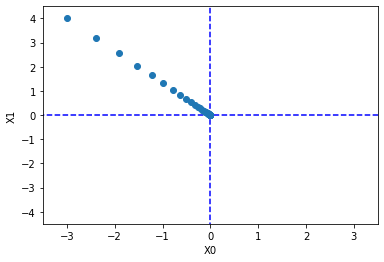

In [17]:
plt.plot([-5, 5], [0, 0], '--b')
plt.plot([0, 0], [-5, 5], '--b')
plt.plot(x_history[:, 0], x_history[:, 1], 'o')

plt.xlim(-3.5, 3.5)
plt.ylim(-4.5, 4.5)
plt.xlabel('X0')
plt.ylabel('X1')
plt.show()

### 神经网络的梯度

神经网络的学习也要求梯度，是指损失函数关于权重参数的梯度。

比如，一个只有一个形状为2 × 3的权重w的神经网络，损失函数用L表示。此时，梯度可以用为：

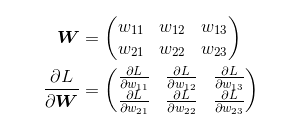

梯度中的元素由各个元素关于w的偏导数组成。

**一个简单的神经网络**

In [18]:
from common.functions import softmax
from common.functions import cross_entropy_error
from common.gradient import numerical_gradient

class SimpleNet:
    def __init__(self):
        # self.W = np.random.randn(2, 3) # 用高斯分布初始化权重
        self.W = np.array([[ 0.40166113, -0.8074828, -0.41460904],
 [ 0.60389954, -0.4302077, -0.02152071]])        
    
    def predict(self, x):
        return np.dot(x, self.W)
    
    def loss(self, x, t):
        z = self.predict(x)
        y = softmax(z)
        loss = cross_entropy_error(y, t)
        return loss

dW是一个形状为2 × 3的二维数组，它是权重矩阵W的梯度，对应着权重矩阵W的每个元素。如：
- w11的梯度约为-0.21，这就表示如果将w11增加h，损失函数的值会减小0.21h。
- w22的梯度约为0.11，这就表示如果将w22增加h，损失函数的值会增大0.11h。

因此，从减小损失函数值的角度来看，w11的梯度为负，则应向负方向更新，w22的梯度为正，则应向正方向更新。从更新的程度来看，w11比w22的贡献要大。

求出神经网络的梯度后，就可以使用梯度下降算法更新权重矩阵W。

dW是一个形状为2 × 3的二维数组，它是权重矩阵W的梯度，对应着权重矩阵W的每个元素。如：
- w11的梯度约为-0.21，这就表示如果将w11增加h，损失函数的值会减小0.21h。
- w22的梯度约为0.11，这就表示如果将w22增加h，损失函数的值会增大0.11h。

因此，从减小损失函数值的角度来看，w11的梯度为负，则应向负方向更新，w22的梯度为正，则应向正方向更新。从更新的程度来看，w11比w22的贡献要大。

求出神经网络的梯度后，就可以使用梯度下降算法更新权重矩阵W。

dW是一个形状为2 × 3的二维数组，它是权重矩阵W的梯度，对应着权重矩阵W的每个元素。如：
- w11的梯度约为-0.21，这就表示如果将w11增加h，损失函数的值会减小0.21h。
- w22的梯度约为0.11，这就表示如果将w22增加h，损失函数的值会增大0.11h。

因此，从减小损失函数值的角度来看，w11的梯度为负，则应向负方向更新，w22的梯度为正，则应向正方向更新。从更新的程度来看，w11比w22的贡献要大。

求出神经网络的梯度后，就可以使用梯度下降算法更新权重矩阵W。

SimpleNet类只有一个实例变量，即形状为2 × 3的权重参数。predict(x)方法用于预测，loss(x,t)方法用于计算损失函数，其中，x是输入，t是标签。

In [19]:
net = SimpleNet()
print(net.W)

[[ 0.40166113 -0.8074828  -0.41460904]
 [ 0.60389954 -0.4302077  -0.02152071]]


In [20]:
x = np.array([0.6, 0.9])
p = net.predict(x)
print(p)

[ 0.78450626 -0.87167661 -0.26813406]


In [21]:
maxIndex = np.argmax(p)
print(maxIndex)

0


In [22]:
t = np.array([1, 0, 0]) # 正确标签
loss = net.loss(x, t)
print(loss)

0.4317050966237486


In [23]:
def fn(W):
    return net.loss(x, t)

# 或使用lambda表达式
fn = lambda W: net.loss(x, t)

dW = numerical_gradient(fn, net.W)
print(dW)

[[-0.21035951  0.07436916  0.13599035]
 [-0.31553927  0.11155374  0.20398552]]


dW是一个形状为2 × 3的二维数组，它是权重矩阵W的梯度，对应着权重矩阵W的每个元素。如：
- w11的梯度约为-0.21，这就表示如果将w11增加h，损失函数的值会减小0.21h。
- w22的梯度约为0.11，这就表示如果将w22增加h，损失函数的值会增大0.11h。

因此，从减小损失函数值的角度来看，w11的梯度为负，则应向负方向更新，w22的梯度为正，则应向正方向更新。从更新的程度来看，w11比w22的贡献要大。

求出神经网络的梯度后，就可以使用梯度下降算法更新权重矩阵W。